In [1]:
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
from time import time
from datetime import datetime
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from tqdm import tqdm
from tqdm import tqdm_gui
import seaborn as sns

In [2]:
### log prior
#   here: beta distribution
#   for instance: previous election
def log_f_theta(theta): 
    log_f=np.log(stats.beta.pdf(theta,253.0425,262.3190)) # Ergebnisse vor vorherigen Übung alfa und beta
                                                          # für jeden Wert von theta bekomme ich die Dichte an dieser Stelle
    return log_f

### log likelihood
#   here: binomial distribution
#   for instance: current surveys
def log_likelihood(theta): # likelihood binomial verteilt.           # theta ist Wahr. für Binomialverteilung
    log_l=np.log(stats.binom.pmf(279,509,theta) )
    return log_l
  
### log posterior
#   assumption: distribution not known
def log_f_theta_x(theta):                    # posterior ist Produkt von prior * likelihood bzw. die Summ von log_prior + log_likelihood
     return log_f_theta(theta) + log_likelihood(theta) 
 

In [3]:
##########################################
### Metropolis-Hastings algorithm
##########################################

### input parameters
# - iter (number of iterations)        # Anzahl der Inseln: wie viele Inseln sollte ich abarbeiten bis komplette Posterior **
# - log_post (logarithm of posterior)  # Bevölkerungszahl von der Insel, wo ich jetzt
# - theta_0 (initial values for unknown parameters)
  
def mh(iterations,log_post,theta_0):      # theta_0 ist Startwert
                                          # 2 verschiedene theta0, um zu schauen, obbeide die gleiche Posterior konvergieren oder nicht!
    
    # sampled vector of posterior
    samples       = np.zeros(iterations)    # wie viele inseln muss ich abarbeiten***
    # initial value
    samples[0]    = theta_0 
    
    # remaining iterations
    for i in tqdm(np.arange(1,iterations,1)):
    
      
        # current
      
        # current logarithm of posterior    # Bevölkerungszahl von der Insel, wo ich gerade bin -> posterior von meinem theta0
        log_post_current = log_post(samples[i-1])
      
        # proposal                          # Proposal ist proportion von anderen Insel
      
        # proposal density (range of theta: 0 - 1)        
        proposal = stats.uniform.rvs(size=1)
        
        # proposed logarithm of posterior
        log_post_proposal = log_post(proposal)
      
        # accept / reject
        
        # what is more likely, the current or the proposal?     # wenn die Politiker große Rat wird
        if stats.uniform.rvs(size=1) < np.exp(log_post_proposal - log_post_current):
            
            
          
            # accept the proposal with probability min(post_proposal / post_current,1) #wenn dieser Wert erfüllt ist, bleibe ich auf dieser Insel
            samples[i] = proposal
          
        else:
            
            # reject the proposal with probability max(1 - post_proposal / post_current,0) ## wenn dieser Wert nicht erfüllt, gehe ich ein Schritt zurück
            samples[i] = samples[i-1]
            
    # return sampled posterior values
    return samples

In [4]:
iterations=100000 # um sauber zu machen -> ich würde eine Verteilung approximieren -> ich sample 2 verschiedene Posterior

Sampled_Posterior_1=mh(iterations=iterations,log_post=log_f_theta_x,theta_0=0.3) # Klausur: ein fehler wenn die beiden werte sind gleiche
Sampled_Posterior_2=mh(iterations=iterations,log_post=log_f_theta_x,theta_0=0.8) # Klausur: ein fehler wenn die beiden werte sind gleiche

  0%|          | 1/99999 [00:00<4:20:26,  6.40it/s]/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
100%|██████████| 99999/99999 [01:48<00:00, 922.88it/s]


Text(0.5, 1.0, 'Traceplot of posterior')

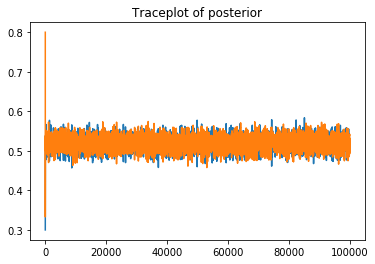

In [5]:
# Posterior plotten 
plt.figure(1)
plt.plot(Sampled_Posterior_1)             
plt.plot(Sampled_Posterior_2)
plt.title('Traceplot of posterior') # 2 posterior aufeinander liegen müssen # dann die Schätzung konvergiert
# 

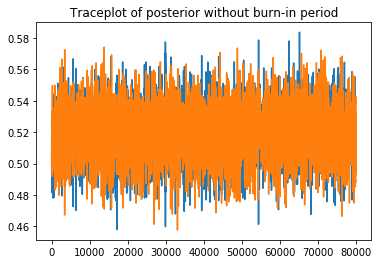

In [6]:
# remove the first values ("burn-in period") # die Phase, die das Algorithmus am Anfang braucht, um +++ stationäres zu konvergieren
# for instance, 20% of all sample values
burn                 = 0.2               # die ersten 20% von meinem Sample nehme ich weg
drop_burn            = np.round(burn*len(Sampled_Posterior_1),decimals=0).astype(int)

# (remaining) traceplot
plt.figure(2)
plt.plot(Sampled_Posterior_1[drop_burn:])             
plt.plot(Sampled_Posterior_2[drop_burn:])
plt.title('Traceplot of posterior without burn-in period')

Full_Posterior=np.concatenate([Sampled_Posterior_1[drop_burn:],Sampled_Posterior_2[drop_burn:]]) #160000 sample wie vile größer als 0.5

# streuung zwischen 0.46 und 0.58 für klausur
# mittelwert 0.52

In [7]:
##########################################
### Comparison with analytical solution
##########################################

# winning probability of Republicans
  
# analytical solution
print('Analytical solution:', 1 - stats.beta.cdf(0.5,532.0425,492.3190))
  
# sampled calues
print('Sampled solution:',sum(Full_Posterior> 0.5 ) / (len(Full_Posterior)))

Analytical solution: 0.8928450544459543
Sampled solution: 0.88856875


Text(0.5, 1.0, 'Sampled vs. analytical Posterior')

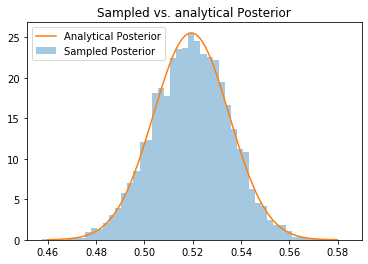

In [8]:
### Histogram
True_posterior=stats.beta.pdf(np.arange(0.46,0.58,0.0001),532.0425,492.3190)

sns.distplot(Full_Posterior,bins=50 ,kde=False,norm_hist=True)
plt.plot(np.arange(0.46,0.58,0.0001),True_posterior)
plt.legend([ 'Analytical Posterior','Sampled Posterior'], loc='upper left')
plt.title('Sampled vs. analytical Posterior')